In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import string
from tqdm import tqdm
import re
import random
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
from gru_train import *

## Dataset

In [7]:
all_sentences = []
with open(sentences_file, 'r') as f:
    all_sentences = f.readlines()
all_sentences = [x.replace('\'', '') for x in all_sentences]
all_sentences = [re.sub('\W+', ' ', x.lower()).strip() for x in all_sentences]

all_sentences = list(set(all_sentences))

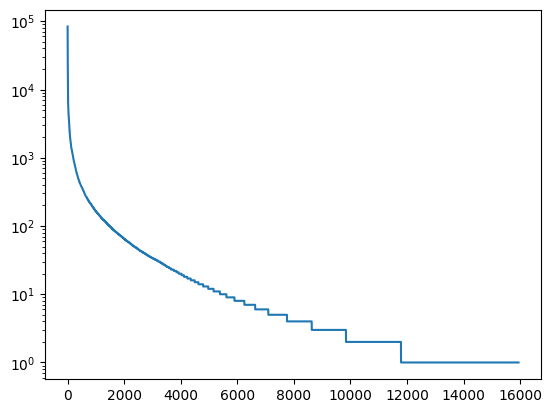

In [8]:
plt.plot(pd.DataFrame(list(' '.join(all_sentences).split(' '))).value_counts().values)
plt.yscale('log')

In [9]:
sentences = compile_sentences(sentences_file, word_count_threshold=10)


Importing sentences...


token set length:  28
unique words:  1123653
word vocabulary length:  10140


In [10]:
train_dataloaders, test_dataloaders = build_datasets(sentences[:10])

## Model

In [11]:
# Example hyperparameters
vocab_size = 28  # a-z and space, \n chars
embed_size = 256
hidden_size = 512
batch_size = 64

# Create the model
model = GRUTextGenerator(vocab_size, embed_size, hidden_size)

## Training

In [ ]:
train(model, train_dataloaders, test_dataloaders, vocab_size, device, epochs=epochs)

In [12]:
load_model(model, 'model_cache/model_epoch_9.pt', device=device)

Model loaded from model_cache/model_epoch_9.pt


# Inference

In [13]:
def vectorise(sentence):
    return torch.tensor([token_dict[x] for x in sentence], dtype=torch.int64, device=device)

def softmax(logits, temperature=1.0):
    scaled_logits = logits / temperature
    exp_logits = np.exp(scaled_logits - np.max(scaled_logits))
    probs = exp_logits / exp_logits.sum()
    return probs

def run_inference(model, sentence, temperature=1.0):
    model.eval()

    input = vectorise(sentence)

    output = model(input)

    logits = output[0][-1, :].detach().numpy()

    # print(logits)

    # Compute probabilities using softmax with temperature
    probs = softmax(logits, temperature)

    # Randomly sample from the probability distribution
    sampled_idx = np.random.choice(len(probs), p=probs)

    if sampled_idx == 27:
        print(probs)

    # sampled_idx = np.argmax(logits)
    # print(sampled_idx)

    # Find the corresponding token
    for a, i in token_dict.items():
        if sampled_idx == i:
            sentence += a
            return sentence

In [15]:
sentence = random.sample(string.ascii_lowercase, 1)[0]
sentence = 'chil'

while sentence[-1] != '\n':
    sentence = run_inference(model, sentence, temperature=0.6)

    print(f'\r\033[K{sentence}', end='', flush=True)
    # print(sentence[-1], end='')

children went them[7.96072900e-01 4.37350067e-08 5.44958652e-07 1.07039355e-08
 8.09315726e-09 3.31604997e-06 1.32327116e-07 2.16541851e-09
 5.41722400e-08 4.18185920e-07 3.50654012e-08 1.91310594e-08
 1.55633995e-06 3.17979652e-06 5.38032872e-08 9.84167741e-07
 8.91808384e-07 1.37995968e-07 2.69923000e-08 2.05136673e-03
 1.59124994e-07 1.05278142e-09 1.30232536e-08 1.23626307e-06
 5.47845158e-10 2.97505104e-10 9.41371495e-11 2.01862961e-01]
children went them


In [16]:
import numpy as np
import json
from json import JSONEncoder


In [17]:
class EncodeTensor(JSONEncoder,Dataset):
    def default(self, obj):
        if isinstance(obj, torch.Tensor):
            return obj.cpu().detach().numpy().tolist()
        return super(json.NpEncoder, self).default(obj)


In [18]:
# x = vectorise(sentence)
# y = model(x)[0]

# np.savetxt('test_data/generative_gru_x.csv', x.detach(), delimiter=',')
# np.savetxt('test_data/generative_gru_y.csv', y.detach(), delimiter=',')

with open('gru_512.json', 'w') as json_file:
    json.dump(model.state_dict(), json_file,cls=EncodeTensor)

## Post Training

In [3]:
import pandas as pd

df = pd.read_csv('train_log.csv')

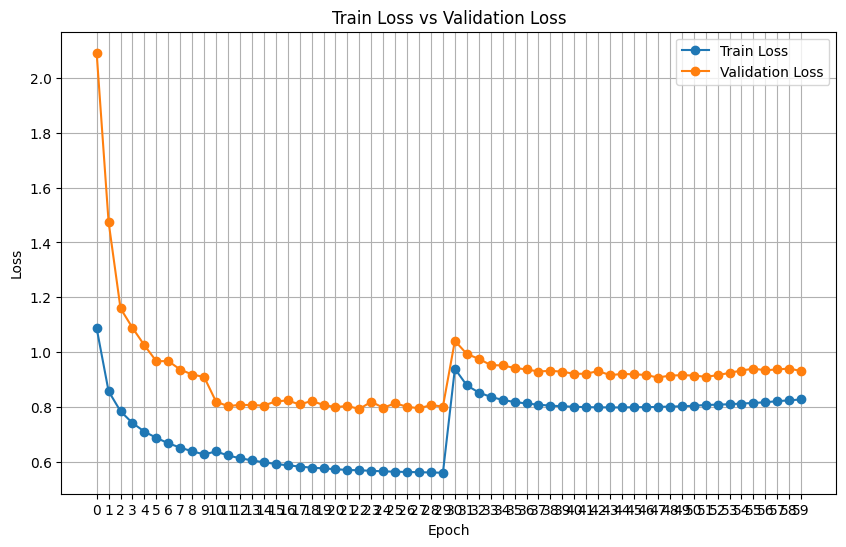

In [4]:
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Train Loss'], label='Train Loss', marker='o')
plt.plot(df.index, df['Validation Loss'], label='Validation Loss', marker='o')

# Adding title and labels
plt.title('Train Loss vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(df.index)  # Set x-ticks to be the epochs for easier reading
plt.legend()             # Show the legend
plt.grid()               # Show grid for better readability
plt.show()               # Display the plot
